In [86]:
from pyspark.sql import SQLContext
from pyspark.ml.feature import MinMaxScaler
from pyspark.sql import functions as sf
from matplotlib import pyplot as plt
from pyspark.sql.functions import col,avg
import pandas as pd
from pyspark.ml.feature import VectorAssembler
import numpy as np
from pyspark.ml.clustering import KMeans
from pyspark.sql import Row
import pyspark

In [87]:
sc.stop()
sc = pyspark.SparkContext(master="spark://172.16.27.208:7077",appName="spark")
sc

<SparkContext master=spark://172.16.27.208:7077 appName=spark>

## Load Average Profile csv

In [88]:
base_path = "/home/test5/Desktop/smart-meters-in-london/"
sqlcontext = SQLContext(sc)
#avg_power_df = sqlcontext.read.format("com.databricks.spark.csv").load(base_path+"avg.csv/*")#csv(base_path+"avg.csv/",header=True,inferSchema=True)
avg_power_df = sqlcontext.read.csv(base_path+"avg.csv",header=True,inferSchema=True).cache()
avg_power_df.count()

3931

## Adding "`" to properly  select OW Analysis exception

### just to be clear, the reason for this is that the column name has a period in it. Spark is in general a little buggy as far as properly supporting backticks throughout codebase, but in this case they're fine

In [89]:
avg_power_df = avg_power_df.drop("_c0")
avg_power_df.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- 00.5: double (nullable = true)
 |-- 01.0: double (nullable = true)
 |-- 01.5: double (nullable = true)
 |-- 02.0: double (nullable = true)
 |-- 02.5: double (nullable = true)
 |-- 03.0: double (nullable = true)
 |-- 03.5: double (nullable = true)
 |-- 04.0: double (nullable = true)
 |-- 04.5: double (nullable = true)
 |-- 05.0: double (nullable = true)
 |-- 05.5: double (nullable = true)
 |-- 06.0: double (nullable = true)
 |-- 06.5: double (nullable = true)
 |-- 07.0: double (nullable = true)
 |-- 07.5: double (nullable = true)
 |-- 08.0: double (nullable = true)
 |-- 08.5: double (nullable = true)
 |-- 09.0: double (nullable = true)
 |-- 09.5: double (nullable = true)
 |-- 10.0: double (nullable = true)
 |-- 10.5: double (nullable = true)
 |-- 11.0: double (nullable = true)
 |-- 11.5: double (nullable = true)
 |-- 12.0: double (nullable = true)
 |-- 12.5: double (nullable = true)
 |-- 13.0: double (nullable = true)
 |-- 13.5: double (nul

In [90]:
old_Feature_cols = []
new_Feature_cols = []
for i in range(1,49):
    if i<20:
        old_Feature_cols.append("0"+str(i*0.5))
    else:
        old_Feature_cols.append(str(i*0.5))
    if i<10:
        new_Feature_cols.append("0"+str(i))
    else:
        new_Feature_cols.append(str(i))
        
for c,n in zip(old_Feature_cols,new_Feature_cols):
            avg_power_df=avg_power_df.withColumnRenamed(c,n)

for i in range(1,len(new_Feature_cols),2):
    avg_power_df = avg_power_df.withColumn(new_Feature_cols[i],avg_power_df[new_Feature_cols[i-1]]+avg_power_df[new_Feature_cols[i]])
    avg_power_df = avg_power_df.drop(new_Feature_cols[i-1])
for i in range(24):
    avg_power_df = avg_power_df.withColumnRenamed(new_Feature_cols[2*i+1],new_Feature_cols[i])
avg_power_df.printSchema()
avg_power_df.take(1)
    

root
 |-- LCLid: string (nullable = true)
 |-- 01: double (nullable = true)
 |-- 02: double (nullable = true)
 |-- 03: double (nullable = true)
 |-- 04: double (nullable = true)
 |-- 05: double (nullable = true)
 |-- 06: double (nullable = true)
 |-- 07: double (nullable = true)
 |-- 08: double (nullable = true)
 |-- 09: double (nullable = true)
 |-- 10: double (nullable = true)
 |-- 11: double (nullable = true)
 |-- 12: double (nullable = true)
 |-- 13: double (nullable = true)
 |-- 14: double (nullable = true)
 |-- 15: double (nullable = true)
 |-- 16: double (nullable = true)
 |-- 17: double (nullable = true)
 |-- 18: double (nullable = true)
 |-- 19: double (nullable = true)
 |-- 20: double (nullable = true)
 |-- 21: double (nullable = true)
 |-- 22: double (nullable = true)
 |-- 23: double (nullable = true)
 |-- 24: double (nullable = true)



[Row(LCLid='MAC000032', 01=3.196002750274723, 02=1.821425820604396, 03=1.547936813186812, 04=1.3894505423076908, 05=1.2057527456043937, 06=0.4959148357142862, 07=0.40925274670329714, 08=0.11987362637362636, 09=0.12936263736263737, 10=0.14601923076923068, 11=0.2570247252747253, 12=0.3462829667582418, 13=0.2852390107142857, 14=0.15830219780219784, 15=0.1238708791208791, 16=0.13864560439560442, 17=0.17894505494505497, 18=0.1615219780219781, 19=0.13884615384615367, 20=0.13737087912087909, 21=0.1437637362637362, 22=0.15412912087912084, 23=0.12270879120879118, 24=0.0785054945054945)]

###### TODO : Scaling Feature using MinMaxSacler or any other can be done

In [91]:
avg_house_data = avg_power_df
new_Feature_cols = new_Feature_cols[0:24]
vecAssembler = VectorAssembler(inputCols=new_Feature_cols, outputCol="features")
df_kmeans = vecAssembler.transform(avg_power_df)
df_kmeans.take(1)

[Row(LCLid='MAC000032', 01=3.196002750274723, 02=1.821425820604396, 03=1.547936813186812, 04=1.3894505423076908, 05=1.2057527456043937, 06=0.4959148357142862, 07=0.40925274670329714, 08=0.11987362637362636, 09=0.12936263736263737, 10=0.14601923076923068, 11=0.2570247252747253, 12=0.3462829667582418, 13=0.2852390107142857, 14=0.15830219780219784, 15=0.1238708791208791, 16=0.13864560439560442, 17=0.17894505494505497, 18=0.1615219780219781, 19=0.13884615384615367, 20=0.13737087912087909, 21=0.1437637362637362, 22=0.15412912087912084, 23=0.12270879120879118, 24=0.0785054945054945, features=DenseVector([3.196, 1.8214, 1.5479, 1.3895, 1.2058, 0.4959, 0.4093, 0.1199, 0.1294, 0.146, 0.257, 0.3463, 0.2852, 0.1583, 0.1239, 0.1386, 0.1789, 0.1615, 0.1388, 0.1374, 0.1438, 0.1541, 0.1227, 0.0785]))]

In [92]:
scaler = MinMaxScaler(inputCol="features",outputCol="scaled_features")
df_kmeans = scaler.fit(df_kmeans).transform(df_kmeans)

# K-Means

## Chosing K

290.13138174785985
211.49258610963807
177.96173377611996
156.31426325944778
131.32919630641857
120.13949296145059
113.016041055532
111.30567101501607
106.11437540430177
103.06278949051061
98.8897042059328
94.6480194161434
93.89862172104006


Text(0.5, 1.0, 'Elbow Method:')

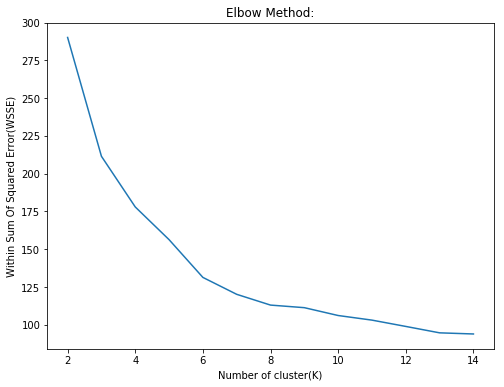

In [55]:
wsse = np.zeros(15)
for k in range(2,15):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaled_features")
    model = kmeans.fit(df_kmeans)
    wsse[k] = model.computeCost(df_kmeans) 
    print(wsse[k])
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,15),wsse[2:15])
ax.set_xlabel('Number of cluster(K)')
ax.set_ylabel('Within Sum Of Squared Error(WSSE)')
ax.set_title("Elbow Method:")

In [56]:
fig.savefig(base_path+"/plot/K-means_elbow_k=8")

### k = 8 from elbow method
### Train Model

In [57]:
k = 8
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaled_features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

for i in range(len(centers)):
    centers[i] = centers[i].tolist()
    centers[i] = ["Cluster "+str(i)] + centers[i]
# print("Cluster Centers: ")
# for center in centers:
#     print(center)
# type(centers)
transformed = model.transform(df_kmeans)
print(transformed.printSchema())
transformed = transformed.withColumnRenamed("prediction","cluster_id")
# transformed.select("cluster_id").show()
transformed.select("LCLid","cluster_id").toPandas().to_csv(base_path+"cluster_info_k_means_k-8.csv", header=True)

root
 |-- LCLid: string (nullable = true)
 |-- 01: double (nullable = true)
 |-- 02: double (nullable = true)
 |-- 03: double (nullable = true)
 |-- 04: double (nullable = true)
 |-- 05: double (nullable = true)
 |-- 06: double (nullable = true)
 |-- 07: double (nullable = true)
 |-- 08: double (nullable = true)
 |-- 09: double (nullable = true)
 |-- 10: double (nullable = true)
 |-- 11: double (nullable = true)
 |-- 12: double (nullable = true)
 |-- 13: double (nullable = true)
 |-- 14: double (nullable = true)
 |-- 15: double (nullable = true)
 |-- 16: double (nullable = true)
 |-- 17: double (nullable = true)
 |-- 18: double (nullable = true)
 |-- 19: double (nullable = true)
 |-- 20: double (nullable = true)
 |-- 21: double (nullable = true)
 |-- 22: double (nullable = true)
 |-- 23: double (nullable = true)
 |-- 24: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)
 |-- prediction: integer (nullable = false)

None


In [58]:
cluster_centroid_rdd = sc.parallelize(centers)
cluster_centroid_rdd = cluster_centroid_rdd.flatMap(lambda x: Row(x))
# cluster_centroid_rdd.collect()
df_cluster_center=sqlcontext.createDataFrame(cluster_centroid_rdd,new_Feature_cols)
len(centers)

8

In [93]:
scaled_feature_list = [list(row) for row in df_kmeans.select("scaled_features").collect()]
scaled_feature_list = [[float(x) for x in list(row[0].values)] for row in scaled_feature_list]
avg_house_data = avg_house_data.drop("LCLid")
scaled_df = sc.parallelize(scaled_feature_list)
scaled_df = scaled_df.flatMap(lambda x : Row(x))
scaled_df = sqlcontext.createDataFrame(scaled_df,avg_house_data.schema)
scaled_df.printSchema()
type(scaled_feature_list[0][0])

root
 |-- 01: double (nullable = true)
 |-- 02: double (nullable = true)
 |-- 03: double (nullable = true)
 |-- 04: double (nullable = true)
 |-- 05: double (nullable = true)
 |-- 06: double (nullable = true)
 |-- 07: double (nullable = true)
 |-- 08: double (nullable = true)
 |-- 09: double (nullable = true)
 |-- 10: double (nullable = true)
 |-- 11: double (nullable = true)
 |-- 12: double (nullable = true)
 |-- 13: double (nullable = true)
 |-- 14: double (nullable = true)
 |-- 15: double (nullable = true)
 |-- 16: double (nullable = true)
 |-- 17: double (nullable = true)
 |-- 18: double (nullable = true)
 |-- 19: double (nullable = true)
 |-- 20: double (nullable = true)
 |-- 21: double (nullable = true)
 |-- 22: double (nullable = true)
 |-- 23: double (nullable = true)
 |-- 24: double (nullable = true)



float

If we don't assign color all plot will be of different color,
by putting ax=ax we are plotting on same graph,
if removed new graph below will be plotted.

Text(0, 0.5, 'Scaled average load profile (Kw/h)')

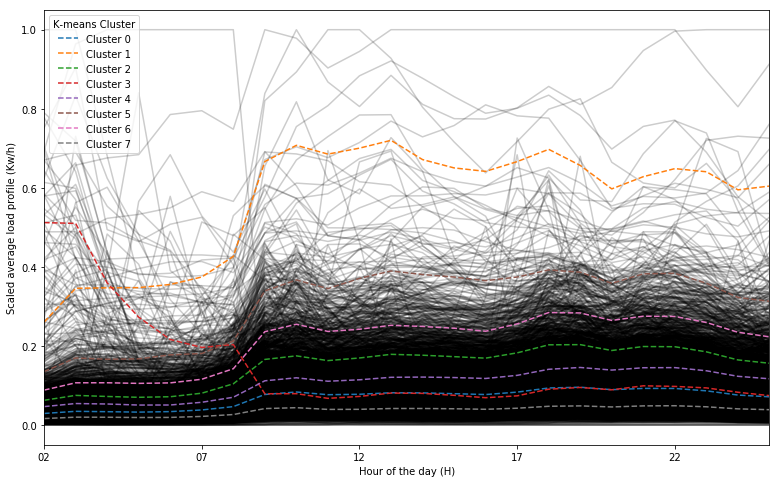

In [66]:
df_cluster_center = df_cluster_center.withColumnRenamed("01","K-means Cluster")
# ax = avg_house_data.toPandas().set_index("LCLid").T.plot(figsize=(13,8), legend=False, color='black',alpha=0.3)
ax = scaled_df.toPandas().T.plot(figsize=(13,8), legend=False, color='black',alpha=0.2)
plot = df_cluster_center.toPandas().set_index("K-means Cluster").T.plot(ax=ax,alpha=2,style='--')
ax.set_xlabel("Hour of the day (H)")
ax.set_ylabel("Scaled average load profile (Kw/h)")
# ax.set_title("K-menas Clu")

In [67]:
plot.get_figure().savefig(base_path+"/plot/cluster-8-means-scaled.png")

# Bisecting K-means

In [94]:
from pyspark.ml.clustering import BisectingKMeans

274.0123490667893
225.3838476696538
156.17569543791396
148.4860532421969
141.2901625450428
129.85254365273053
110.95569003184966
109.87939318940913
108.73577668478671


Text(0.5, 1.0, 'Elbow Method:')

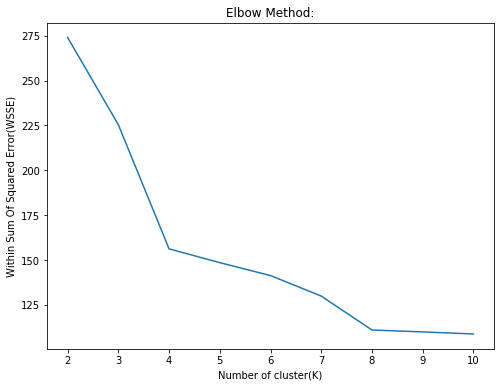

In [95]:
wsse = np.zeros(11)
for k in range(2,11):
    bkm = BisectingKMeans().setK(k).setSeed(5).setFeaturesCol("scaled_features")
    model = bkm.fit(df_kmeans)
    wsse[k] = model.computeCost(df_kmeans) 
    print(wsse[k])
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),wsse[2:11])
ax.set_xlabel('Number of cluster(K)')
ax.set_ylabel('Within Sum Of Squared Error(WSSE)')
ax.set_title("Elbow Method:")

In [96]:
fig.savefig(base_path+"/plot/BK-means_elbow_k=8")

## k = 8 from elbow method

In [97]:
k = 8
bkm = BisectingKMeans().setK(8).setSeed(1).setFeaturesCol("scaled_features")
bkm_model = bkm.fit(df_kmeans)
bkm_cluster_center = bkm_model.clusterCenters()
bkm_transformed = bkm_model.transform(df_kmeans)
bkm_transformed = bkm_transformed.withColumnRenamed("prediction","cluster_id")
# transformed.select("cluster_id").show()
bkm_transformed.select("LCLid","cluster_id").toPandas().to_csv(base_path+"cluster_info_b-k_means_k-8.csv", header=True)

In [98]:
print(len(bkm_cluster_center))

8


In [99]:
for i in range(len(bkm_cluster_center)):
    bkm_cluster_center[i] = bkm_cluster_center[i].tolist()
    bkm_cluster_center[i] = ["Cluster "+str(i)] + bkm_cluster_center[i]
bkm_cluster_centroid_rdd = sc.parallelize(bkm_cluster_center)
bkm_cluster_centroid_rdd = bkm_cluster_centroid_rdd.flatMap(lambda x: Row(x))
# cluster_centroid_rdd.collect()
bkm_df_cluster_center=sqlcontext.createDataFrame(bkm_cluster_centroid_rdd,new_Feature_cols)

Text(0, 0.5, 'Scaled average load profile (Kw/h)')

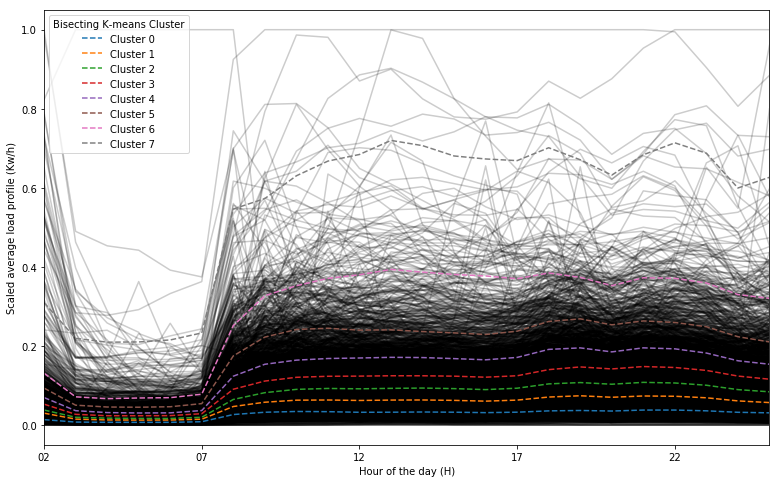

In [101]:
bkm_df_cluster_center = bkm_df_cluster_center.withColumnRenamed("01","Bisecting K-means Cluster")
# ax = avg_house_data.toPandas().set_index("LCLid").T.plot(figsize=(13,8), legend=False, color='black',alpha=0.3)
ax = scaled_df.toPandas().T.plot(figsize=(13,8), legend=False, color='black',alpha=0.2)
plot = bkm_df_cluster_center.toPandas().set_index("Bisecting K-means Cluster").T.plot(ax=ax,alpha=2,style='--')
ax.set_xlabel("Hour of the day (H)")
ax.set_ylabel("Scaled average load profile (Kw/h)")
# ax.set_title("K-menas Clu")

In [102]:
plot.get_figure().savefig(base_path+"/plot/cluster-8bk-means-scaled.png")